In [ ]:
!pip install neo4j pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 24.1 MB/s eta 0:00:00


In [ ]:
from neo4j import GraphDatabase
import pandas as pd
import time

# --- KONFIGURASI NEO4J AURA ANDA ---
URI = "neo4j+s://94a80fb4.databases.neo4j.io" # Ganti dengan URI Aura Anda
AUTH = ("neo4j", "Kizq6HBqDDgKUhW3f5JPkHxqGlO1nKHwejkM_UhJYfw") # Ganti dengan Username & Password

driver = GraphDatabase.driver(URI, auth=AUTH)

def run_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters)
        return [record for record in result]

def run_write(query, parameters=None):
    with driver.session() as session:
        result = session.execute_write(lambda tx: tx.run(query, parameters).consume())
        return result

print("Koneksi berhasil disiapkan!")

Koneksi berhasil disiapkan!


In [ ]:
# Membaca CSV
movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')

print(f"Movies loaded: {movies_df.shape}")
print(f"Ratings loaded: {ratings_df.shape}")

# Preprocessing Genres untuk Content-Based Filtering
# Mengubah "Action|Adventure" menjadi list ['Action', 'Adventure']
movies_df['genres_list'] = movies_df['genres'].apply(lambda x: x.split('|'))

display(movies_df.head(2))
display(ratings_df.head(2))

Movies loaded: (9742, 3)
Ratings loaded: (100836, 4)


,movieId,title,genres,genres_list
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]"


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247


In [ ]:
run_write("MATCH (n) DETACH DELETE n")
print("Database dibersihkan.")

# Membuat Constraints (Index Unik) untuk performa
constraints = [
    "CREATE CONSTRAINT IF NOT EXISTS FOR (u:User) REQUIRE u.userId IS UNIQUE",
    "CREATE CONSTRAINT IF NOT EXISTS FOR (m:Movie) REQUIRE m.movieId IS UNIQUE",
    "CREATE CONSTRAINT IF NOT EXISTS FOR (g:Genre) REQUIRE g.name IS UNIQUE"
]

for q in constraints:
    run_write(q)
    print(f"Executed: {q}")

Database dibersihkan.
Executed: CREATE CONSTRAINT IF NOT EXISTS FOR (u:User) REQUIRE u.userId IS UNIQUE
Executed: CREATE CONSTRAINT IF NOT EXISTS FOR (m:Movie) REQUIRE m.movieId IS UNIQUE
Executed: CREATE CONSTRAINT IF NOT EXISTS FOR (g:Genre) REQUIRE g.name IS UNIQUE


In [ ]:
print("Mulai proses ingestion (Mungkin memakan waktu beberapa menit)...")

# 1. Ingest Movies & Genres
# (Bagian ini tidak error, tapi disertakan agar Cell lengkap)
movie_query = """
UNWIND $rows AS row
MERGE (m:Movie {movieId: row.movieId})
SET m.title = row.title
WITH m, row
UNWIND row.genres AS genre
MERGE (g:Genre {name: genre})
MERGE (m)-[:IN_GENRE]->(g)
"""

movies_data = []
for _, row in movies_df.iterrows():
    movies_data.append({
        'movieId': int(row['movieId']),
        'title': row['title'],
        'genres': row['genres_list']
    })

batch_size = 1000
for i in range(0, len(movies_data), batch_size):
    batch = movies_data[i:i+batch_size]
    run_write(movie_query, parameters={'rows': batch})
    print(f"Processed Movies batch {i} to {i+len(batch)}")

# 2. Ingest Ratings (FIXED QUERY)
# Penambahan 'WITH row, u' menjembatani MERGE (Write) dan MATCH (Read)
rating_query = """
UNWIND $rows AS row
MERGE (u:User {userId: row.userId})
WITH row, u
MATCH (m:Movie {movieId: row.movieId})
MERGE (u)-[r:RATED]->(m)
SET r.rating = toFloat(row.rating), r.timestamp = row.timestamp
"""

ratings_data = ratings_df[['userId', 'movieId', 'rating', 'timestamp']].to_dict('records')

print("Starting Ratings Ingestion...")
for i in range(0, len(ratings_data), batch_size):
    batch = ratings_data[i:i+batch_size]
    run_write(rating_query, parameters={'rows': batch})
    if i % 5000 == 0:
        print(f"Processed Ratings batch {i}...")

print("Ingestion Selesai! Graph telah terbentuk.")

Mulai proses ingestion (Mungkin memakan waktu beberapa menit)...
Processed Movies batch 0 to 1000
Processed Movies batch 1000 to 2000
Processed Movies batch 2000 to 3000
Processed Movies batch 3000 to 4000
Processed Movies batch 4000 to 5000
Processed Movies batch 5000 to 6000
Processed Movies batch 6000 to 7000
Processed Movies batch 7000 to 8000
Processed Movies batch 8000 to 9000
Processed Movies batch 9000 to 9742
Starting Ratings Ingestion...
Processed Ratings batch 0...
Processed Ratings batch 5000...
Processed Ratings batch 10000...
Processed Ratings batch 15000...
Processed Ratings batch 20000...
Processed Ratings batch 25000...
Processed Ratings batch 30000...
Processed Ratings batch 35000...
Processed Ratings batch 40000...
Processed Ratings batch 45000...
Processed Ratings batch 50000...
Processed Ratings batch 55000...
Processed Ratings batch 60000...
Processed Ratings batch 65000...
Processed Ratings batch 70000...
Processed Ratings batch 75000...
Processed Ratings batch 8

In [ ]:
# Cell 6: Collaborative Filtering (User-Based) dengan Persentase

def get_collaborative_recommendations(user_id, limit=10):
    query = """
    // 1. Cari User Lain yang punya selera mirip (Link Prediction Core)
    MATCH (target:User {userId: $userId})-[r1:RATED]->(m:Movie)<-[r2:RATED]-(other:User)

    // Filter minimal 3 film sama agar statistik valid
    WITH target, other, COUNT(m) AS common_movies,
         COLLECT(r1.rating) AS target_ratings,
         COLLECT(r2.rating) AS other_ratings
    WHERE common_movies > 3

    // 2. Hitung Cosine Similarity
    WITH target, other, common_movies,
         REDUCE(s = 0.0, k in range(0, size(target_ratings)-1) | s + target_ratings[k] * other_ratings[k]) AS dot_product,
         REDUCE(s = 0.0, r in target_ratings | s + r^2) AS target_norm_sq,
         REDUCE(s = 0.0, r in other_ratings | s + r^2) AS other_norm_sq

    WITH target, other, dot_product / (sqrt(target_norm_sq) * sqrt(other_norm_sq)) AS similarity
    WHERE similarity > 0.6  // Threshold kemiripan

    // 3. Prediksi Film (Apa yang ditonton 'other' tapi belum ditonton 'target')
    MATCH (other)-[r:RATED]->(rec:Movie)
    WHERE NOT EXISTS( (target)-[:RATED]->(rec) )

    // 4. Scoring: Rating Teman dikali Kemiripan Teman
    RETURN rec.title AS Movie,
           rec.movieId AS ID,
           SUM(r.rating * similarity) AS Raw_Score
    ORDER BY Raw_Score DESC
    LIMIT $limit
    """

    # Eksekusi Query
    results = run_query(query, parameters={'userId': user_id, 'limit': limit})
    df = pd.DataFrame([r.data() for r in results])

    if df.empty:
        print("Belum cukup data untuk rekomendasi.")
        return df

    # Normalisasi ke Persentase (Python Side)
    max_score = df['Raw_Score'].max()
    if max_score > 0:
        df['Match_Percentage'] = (df['Raw_Score'] / max_score) * 100
    else:
        df['Match_Percentage'] = 0

    # Formatting Tampilan
    df['Match %'] = df['Match_Percentage'].apply(lambda x: f"{x:.1f}%")

    # Rapikan kolom
    return df[['Movie', 'ID', 'Match %', 'Raw_Score']]

print("Fungsi Collaborative Filtering (Percentage Mode) Siap!")

Fungsi Collaborative Filtering (Percentage Mode) Siap!


In [ ]:
# Cell 7: Hybrid Recommendation Engine (Collaborative + Content-Based Bonus)

def get_hybrid_recommendations(user_id, limit=10):
    query = """
    // --- PART 1: COLLABORATIVE FILTERING ---
    MATCH (target:User {userId: $userId})-[r1:RATED]->(m:Movie)<-[r2:RATED]-(other:User)
    WITH target, other, COUNT(m) AS common_movies,
         COLLECT(r1.rating) AS target_ratings, COLLECT(r2.rating) AS other_ratings
    WHERE common_movies > 2

    // Hitung Similarity
    WITH target, other, common_movies,
         REDUCE(s = 0.0, k in range(0, size(target_ratings)-1) | s + target_ratings[k] * other_ratings[k]) AS dot_product,
         REDUCE(s = 0.0, r in target_ratings | s + r^2) AS target_norm_sq,
         REDUCE(s = 0.0, r in other_ratings | s + r^2) AS other_norm_sq
    WITH target, other, dot_product / (sqrt(target_norm_sq) * sqrt(other_norm_sq)) AS user_similarity
    WHERE user_similarity > 0.6

    // Cari Kandidat
    MATCH (other)-[r:RATED]->(rec:Movie)
    WHERE NOT EXISTS( (target)-[:RATED]->(rec) )

    // --- PART 2: CONTENT-BASED BOOSTING ---
    // Hitung skor dasar dulu
    WITH target, rec, SUM(r.rating * user_similarity) AS cf_score

    // Cek apakah Genre film kandidat (rec) SAMA dengan Genre film favorit user?
    OPTIONAL MATCH (target)-[r_target:RATED]->(:Movie)-[:IN_GENRE]->(g:Genre)<-[:IN_GENRE]-(rec)
    WHERE r_target.rating >= 4.0 // Hanya cek genre dari film yang User SUKA

    // Hitung jumlah genre yang cocok
    WITH rec, cf_score, COUNT(DISTINCT g) AS matching_genres

    // --- PART 3: FINAL SCORING ---
    // Rumus: Skor CF + (Jumlah Genre Cocok * 0.5)
    RETURN rec.title AS Movie,
           rec.movieId AS ID,
           (cf_score + (matching_genres * 0.5)) AS Raw_Score
    ORDER BY Raw_Score DESC
    LIMIT $limit
    """

    # Eksekusi
    results = run_query(query, parameters={'userId': user_id, 'limit': limit})
    df = pd.DataFrame([r.data() for r in results])

    if df.empty:
        return df

    # Normalisasi ke Persentase
    max_score = df['Raw_Score'].max()
    if max_score > 0:
        df['Match_Percentage'] = (df['Raw_Score'] / max_score) * 100
    else:
        df['Match_Percentage'] = 0

    df['Match %'] = df['Match_Percentage'].apply(lambda x: f"{x:.1f}%")

    return df[['Movie', 'ID', 'Match %', 'Raw_Score']]

print("Fungsi Hybrid Filtering (Percentage Mode) Siap!")

Fungsi Hybrid Filtering (Percentage Mode) Siap!


In [ ]:
# Cell 8: Demo & Perbandingan

TARGET_USER = 99

print(f"=== REKOMENDASI METODE 1: COLLABORATIVE ONLY (User {TARGET_USER}) ===")
df_collab = get_collaborative_recommendations(TARGET_USER)
display(df_collab)

print("\n" + "="*80 + "\n")

print(f"=== REKOMENDASI METODE 2: HYBRID (User {TARGET_USER}) ===")
df_hybrid = get_hybrid_recommendations(TARGET_USER)
display(df_hybrid)

=== REKOMENDASI METODE 1: COLLABORATIVE ONLY (User 99) ===


,Movie,ID,Match %,Raw_Score
0,Forrest Gump (1994),356,100.0%,928.995548
1,"Silence of the Lambs, The (1991)",593,83.7%,777.430544
2,Braveheart (1995),110,79.0%,733.846931
3,Jurassic Park (1993),480,76.3%,708.522905
4,Terminator 2: Judgment Day (1991),589,72.8%,676.537949
5,Star Wars: Episode IV - A New Hope (1977),260,68.6%,637.455357
6,"Matrix, The (1999)",2571,68.5%,636.098135
7,Seven (a.k.a. Se7en) (1995),47,68.0%,631.718888
8,"Fugitive, The (1993)",457,67.4%,626.599051
9,"Usual Suspects, The (1995)",50,66.5%,617.823933




=== REKOMENDASI METODE 2: HYBRID (User 99) ===


,Movie,ID,Match %,Raw_Score
0,Forrest Gump (1994),356,100.0%,1034.709756
1,"Silence of the Lambs, The (1991)",593,83.4%,863.396388
2,Braveheart (1995),110,75.2%,778.241537
3,"Matrix, The (1999)",2571,74.3%,768.543448
4,Jurassic Park (1993),480,71.7%,742.167781
5,Terminator 2: Judgment Day (1991),589,70.8%,732.738473
6,Star Wars: Episode IV - A New Hope (1977),260,69.9%,723.392415
7,"Usual Suspects, The (1995)",50,66.4%,687.231590
8,Seven (a.k.a. Se7en) (1995),47,65.9%,681.605486
9,Star Wars: Episode V - The Empire Strikes Back...,1196,65.3%,675.172551


In [ ]:
# Cell 9: Evaluasi Akurasi (Accuracy Test)
import random

def evaluate_accuracy(user_id, k=20):
    print(f"--- Memulai Evaluasi untuk User {user_id} ---")

    # 1. AMBIL GROUND TRUTH (Film yang disukai user)
    query_ground_truth = """
    MATCH (u:User {userId: $userId})-[r:RATED]->(m:Movie)
    WHERE r.rating >= 4.0
    RETURN m.movieId AS id, m.title AS title, r.rating AS rating, r.timestamp AS timestamp
    """
    liked_movies = run_query(query_ground_truth, {'userId': user_id})
    liked_df = pd.DataFrame([r.data() for r in liked_movies])

    if len(liked_df) < 5:
        print("User data terlalu sedikit.")
        return

    # 2. SPLIT & HIDE (Sembunyikan 20% data)
    test_size = int(len(liked_df) * 0.2)
    test_set = liked_df.sample(n=test_size, random_state=42)
    test_movie_ids = test_set['id'].tolist()

    # Hapus relasi sementara
    run_write("MATCH (u:User {userId: $userId})-[r:RATED]->(m:Movie) WHERE m.movieId IN $ids DELETE r",
              {'userId': user_id, 'ids': test_movie_ids})

    try:
        # 3. PREDIKSI (Pakai metode Hybrid)
        recs = get_hybrid_recommendations(user_id, limit=k)

        # 4. HITUNG HITS
        hits = []
        if not recs.empty:
            rec_ids = recs['ID'].tolist()
            hits = [mid for mid in rec_ids if mid in test_movie_ids]

        accuracy = len(hits) / len(test_movie_ids) if len(test_movie_ids) > 0 else 0

        print(f"Film Hidden: {len(test_movie_ids)} item.")
        print(f"Sistem berhasil menebak: {len(hits)} item.")
        print(f"Akurasi Recall: {accuracy * 100:.2f}%")

    finally:
        # 5. RESTORE DATA (Kembalikan data yang dihapus)
        restore_query = """
        UNWIND $rows AS row
        MATCH (u:User {userId: $userId}), (m:Movie {movieId: row.id})
        MERGE (u)-[r:RATED]->(m)
        SET r.rating = row.rating, r.timestamp = row.timestamp
        """
        run_write(restore_query, {'userId': user_id, 'rows': test_set.to_dict('records')})
        print("Data user berhasil dikembalikan.")

# Jalankan Test
evaluate_accuracy(TARGET_USER)

--- Memulai Evaluasi untuk User 99 ---
Film Hidden: 7 item.
Sistem berhasil menebak: 1 item.
Akurasi Recall: 14.29%
Data user berhasil dikembalikan.


=== 1. PREPARING DATA SPLIT (80/20) ===
Total Data: 61716
Training Set (Ingested to Graph): 49372
Validation Set (Hidden from Graph): 12344

=== 2. REBUILDING GRAPH (TRAINING DATA ONLY) ===
Ingesting Movies...
Ingesting Training Ratings...
Graph Training selesai dibangun!

=== 3. GENERATING PREDICTIONS ===
Generating negative samples...
Running prediction for 2000 pairs...

HASIL VALIDASI ML (Validation Split 20%)
ROC AUC Score : 0.7021


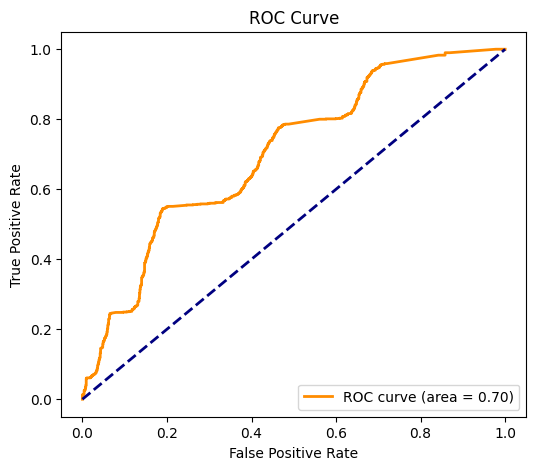

In [ ]:
# Cell 10: ML Evaluation (FIXED - Handling Cold Start)
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import random

def run_ml_validation():
    print("=== 1. PREPARING DATA SPLIT (80/20) ===")

    # Ambil semua data rating positif
    all_ratings = ratings_df[ratings_df['rating'] >= 3.5][['userId', 'movieId', 'rating', 'timestamp']]

    # Split Data: 80% Train, 20% Test
    train_data, test_data = train_test_split(all_ratings, test_size=0.2, random_state=42)

    print(f"Total Data: {len(all_ratings)}")
    print(f"Training Set (Ingested to Graph): {len(train_data)}")
    print(f"Validation Set (Hidden from Graph): {len(test_data)}")

    # === 2. RE-BUILD GRAPH WITH ONLY TRAINING DATA ===
    print("\n=== 2. REBUILDING GRAPH (TRAINING DATA ONLY) ===")

    run_write("MATCH (n) DETACH DELETE n")

    constraints = [
        "CREATE CONSTRAINT IF NOT EXISTS FOR (u:User) REQUIRE u.userId IS UNIQUE",
        "CREATE CONSTRAINT IF NOT EXISTS FOR (m:Movie) REQUIRE m.movieId IS UNIQUE",
        "CREATE CONSTRAINT IF NOT EXISTS FOR (g:Genre) REQUIRE g.name IS UNIQUE"
    ]
    for q in constraints: run_write(q)

    # Ingest Movies
    print("Ingesting Movies...")
    movie_query = """
    UNWIND $rows AS row
    MERGE (m:Movie {movieId: row.movieId})
    SET m.title = row.title
    WITH m, row
    UNWIND row.genres AS genre
    MERGE (g:Genre {name: genre})
    MERGE (m)-[:IN_GENRE]->(g)
    """

    movies_batch = []
    for _, row in movies_df.iterrows():
        movies_batch.append({
            'movieId': int(row['movieId']),
            'title': row['title'],
            'genres': row['genres_list']
        })

    for i in range(0, len(movies_batch), 1000):
        run_write(movie_query, parameters={'rows': movies_batch[i:i+1000]})

    # Ingest ONLY TRAINING RATINGS
    print("Ingesting Training Ratings...")
    rating_query = """
    UNWIND $rows AS row
    MERGE (u:User {userId: row.userId})
    WITH row, u
    MATCH (m:Movie {movieId: row.movieId})
    MERGE (u)-[r:RATED]->(m)
    SET r.rating = toFloat(row.rating)
    """

    train_batch = train_data.to_dict('records')
    for i in range(0, len(train_batch), 1000):
        run_write(rating_query, parameters={'rows': train_batch[i:i+1000]})

    print("Graph Training selesai dibangun!")

    # === 3. PREPARE TEST DATA ===
    print("\n=== 3. GENERATING PREDICTIONS ===")

    sample_size = 1000
    if len(test_data) > sample_size:
        positive_samples = test_data.sample(n=sample_size, random_state=42)
    else:
        positive_samples = test_data

    pos_pairs = list(zip(positive_samples['userId'], positive_samples['movieId']))
    y_true = [1] * len(pos_pairs)

    # Negative Samples
    neg_pairs = []
    all_movie_ids = movies_df['movieId'].unique()
    all_user_ids = ratings_df['userId'].unique()
    existing_pairs = set(zip(ratings_df['userId'], ratings_df['movieId']))

    print("Generating negative samples...")
    while len(neg_pairs) < len(pos_pairs):
        u = random.choice(all_user_ids)
        m = random.choice(all_movie_ids)
        if (u, m) not in existing_pairs:
            neg_pairs.append((u, m))

    y_true.extend([0] * len(neg_pairs))
    all_pairs_to_test = pos_pairs + neg_pairs

    # === 4. PREDICT SCORES (FIXED QUERY) ===
    # Perubahan Utama: Menggunakan OPTIONAL MATCH di awal
    prediction_query = """
    UNWIND $pairs AS pair

    // Gunakan OPTIONAL MATCH agar baris tidak hilang jika Node tidak ada (Cold Start)
    OPTIONAL MATCH (u:User {userId: pair[0]})
    OPTIONAL MATCH (m:Movie {movieId: pair[1]})

    // Hitung Collaborative Score
    // Logika: Jika u/m null, path ini tidak akan match, score jadi 0 (Aman)
    OPTIONAL MATCH (u)-[r1:RATED]->(common_movie)<-[r2:RATED]-(other)-[r3:RATED]->(m)
    WITH u, m, other, r1, r2, r3

    WITH u, m, collect(r1.rating) as u_ratings, collect(r2.rating) as other_ratings, count(other) as common_count
    WITH u, m,
         REDUCE(s = 0.0, i in range(0, size(u_ratings)-1) | s + u_ratings[i] * other_ratings[i]) as dot,
         REDUCE(s = 0.0, r in u_ratings | s + r^2) as norm1,
         REDUCE(s = 0.0, r in other_ratings | s + r^2) as norm2

    WITH u, m, SUM(CASE WHEN norm1 > 0 AND norm2 > 0 THEN (dot / (sqrt(norm1)*sqrt(norm2))) ELSE 0 END) as collab_score

    // Hitung Content-Based Score
    OPTIONAL MATCH (u)-[r_hist:RATED]->(:Movie)-[:IN_GENRE]->(g:Genre)<-[:IN_GENRE]-(m)
    WHERE r_hist.rating >= 4.0

    WITH u, m, collab_score, COUNT(DISTINCT g) as genre_matches

    // Return Score, pastikan tidak null
    RETURN COALESCE(collab_score + (genre_matches * 0.5), 0.0) as score
    """

    query_params = [[int(u), int(m)] for u, m in all_pairs_to_test]

    print(f"Running prediction for {len(query_params)} pairs...")
    y_scores = []

    batch_q_size = 100
    for i in range(0, len(query_params), batch_q_size):
        batch = query_params[i:i+batch_q_size]
        result = run_query(prediction_query, {'pairs': batch})

        # Jaga-jaga jika masih ada yang null/hilang
        current_scores = [r['score'] for r in result]

        # Pading jika Neo4j entah kenapa masih drop baris (Safety Net Python)
        expected_len = len(batch)
        actual_len = len(current_scores)
        if actual_len < expected_len:
            # Isi sisanya dengan 0
            current_scores.extend([0.0] * (expected_len - actual_len))

        y_scores.extend(current_scores)

    # === 5. CALCULATE METRICS ===
    # Pastikan panjang array sama sebelum masuk Scikit-Learn
    min_len = min(len(y_true), len(y_scores))
    y_true = y_true[:min_len]
    y_scores = y_scores[:min_len]

    auc_score = roc_auc_score(y_true, y_scores)
    pr_auc_score = average_precision_score(y_true, y_scores)

    print("\n" + "="*40)
    print(f"HASIL VALIDASI ML (Validation Split 20%)")
    print("="*40)
    print(f"ROC AUC Score : {auc_score:.4f}")

    print("="*40)


    # Plotting
    fig, ax1 = plt.subplots(figsize=(6, 5))

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend(loc="lower right")

    plt.show()


# Jalankan Validasi Fixed
run_ml_validation()